In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import plotly as py
from chart_studio.plotly import plot, iplot
import plotly.graph_objects as go
import numpy as np
plt.style.use('ggplot')
pd.__version__

'0.23.4'

In [2]:
# all files stored on ~/Input folder
SSF = pd.read_csv("Input/Subsidies-SSF.csv")
# newly created split based on subsidy subtypes
SSF_unknown = pd.read_csv("Input/Unknown Amounts-SSF.csv")
# newly split but based on subsidies data points that include unknown values (evidence of subsidy but no amount found)
SSF_2009 = pd.read_csv("Input/SSF_2009.csv")
# Subsidies split based on 2009 total subsidies database (see Schuhbauer et al 2017)
Countrydata = pd.read_csv("Input/Country_Data.csv")
# UN based information on maritime countries 
Subsidytypes = pd.read_csv("Input/Subsidy_types.csv")
# Subsidy Categories, Types and Classes
Subsidies2018 = pd.read_csv("Input/Subsidies_2018_all.csv")
# Total Subsidies database (see Sumaila et al 2019)

In [3]:
SSF_2009 = SSF_2009.rename(columns = {'Countries':'Country'})
# rename the column name 'Countries' to 'Country'

In [4]:
# prepare unknown amounts where we have SSF split data but no reported total subsidies amounts
SSF_unknown['SSF_prop'] =  SSF_unknown['SSF percentage']/100
# compute proportion out of percentage for unknown values
SSF_unknown_type = SSF_unknown.groupby(['Country','Type'], as_index = False).mean()
# merge/group the data from subtype to type level
SSF_unknown_type = SSF_unknown_type.loc[:,['Country', 'Type','SSF_prop']]
# shorten unknown dataframe so it can be added to SSF_Type data


In [5]:
# prepare SSF dataframe and concat with unknown
SSF['SSF_amount'] =  SSF['Amount'] * (SSF['SSF percentage']/100)
# compute the actual mount of SSF subsidies using the percentage
SSF_type = SSF.groupby(['Country','Type'], as_index = False).sum()
# group by Type to add all subtypes together
SSF_type['SSF_prop'] = SSF_type['SSF_amount']/SSF_type['Amount']
# compute proportion for SSF per Country and Type
SSF_type_loc = SSF_type.loc[:,['Country', 'Type','SSF_prop']]

SSF_type_all = pd.concat([SSF_type_loc, SSF_unknown_type])
# add unknown with SSF proportions

SSF_class = pd.merge(left = SSF_type_all, right = Subsidytypes, how = 'left')
# change Type into Class to avoid any wording/spelling difference when working with 2009 dataframes
SSF_class = SSF_class.loc[:,['Country', 'SSF_prop', 'Class']]

In [6]:
# merge with 2018 USD amount full Subsidy data base
Subsidies2018_short = Subsidies2018.loc[:,['Country','Class','Constant 2018 USD']]
# reduce 2018 dataframe
SSF_amounts = pd.merge(left = SSF_class, right = Subsidies2018_short, how = 'left')
# merge with SSF proportions so USD SSF amount can be computed based on full data set
SSF_subregions = pd.merge(left = SSF_amounts, right = Countrydata, how = 'left')
# merge with country data to prep for subregion averages
SSF_subregions['SSF_amount'] = SSF_subregions['Constant 2018 USD']*SSF_subregions['SSF_prop']
# compute SSF amount in USD from proportions
SSF_subregion_sum = SSF_subregions.groupby(['Subregion','Class'], as_index = False).sum()
# sum all amounts and all SSF-amounts per subregion and Class
SSF_subregion_sum = SSF_subregion_sum.loc[:,['Subregion','Class','Constant 2018 USD','SSF_amount']]
# shorten dataframe
SSF_subregion_sum['prop_SSF_subregion'] = SSF_subregion_sum['SSF_amount']/SSF_subregion_sum['Constant 2018 USD']
# compute SSF proportion per subregion and Class


In [7]:

# prepare 2009 SSF split data to use to fill gaps where we have no SSF subregion proportion from 2018 dataset
SSF_2009_short = SSF_2009.loc[:,['RegionName','Subregion', 'Country','Type','total_subsidies',
                                 'SSF_subsidies_percent_all','SSF subsidies']]
SSF_2009_short = SSF_2009_short.fillna(0)
# fill all empty spaces (nan) with zeros
SSF_2009_short.columns = ['RegionName', 'Subregion', 'Country', 'Class', 'total_subsidies','SSF_subsidies_percent_all','SSF subsidies']
# rename column header Type to Class
SSF_2009_subregion = SSF_2009_short.groupby(['Subregion','Class'], as_index=False).sum()
# summ total subsidies and SSF subsidies per subregion and class
SSF_2009_subregion['prop_subregion_2009'] = SSF_2009_subregion['SSF subsidies'] / SSF_2009_subregion['total_subsidies']
# compute proportion of SSF subsidies per subregion from 2009 dataset
SSF_2009_subregion = SSF_2009_subregion.loc[:,['Subregion','Class','prop_subregion_2009']]
# shorten dataframe
SSF_2009_adjust = pd.merge(left = SSF_2009_short, right = SSF_2009_subregion, how = 'left')
# merge mean by subregiond ata with original data

SSF_2009_adjust['factor'] = SSF_2009_adjust['SSF_subsidies_percent_all'] / SSF_2009_adjust['prop_subregion_2009']
# compute adjustment factor for every country and every subsidy type
SSF_2009_adjust = SSF_2009_adjust.loc[:,['RegionName','Subregion','Country','Class',
                                         'SSF_subsidies_percent_all','prop_subregion_2009','factor']]
SSF_2009_adjust.columns = ['RegionName', 'Subregion', 'Country', 'Class','SSF_subsidies_2009', 'prop_subregion_2009', 'factor']

In [8]:
# use all Subsidies2018 as the baseline  to merge everything onto its right side
Subsidies_SSF_2018 = pd.merge(left = Subsidies2018, right = SSF_class, how = 'left' )
# merge SSF_prop where available to Subsidies2018 baseline dataframe
Subsidies_SSF_2018 = pd.merge(left = Subsidies_SSF_2018, right = Countrydata, how ='left' )
# add country data to have subregion included
Subsidies_SSF_2018 = Subsidies_SSF_2018.loc[:,['RegionName', 'Country', 'Class', 'Category', 'Type',
                                               'Constant 2018 USD', 'Data Type', 'SSF_prop', 'Subregion']]
# shorten df to only necessary columns

SSF_subregion_2018 = SSF_subregion_sum.loc[:,['Subregion', 'Class','prop_SSF_subregion']]
# shorten datatframe including SSF propo per subregion
Subsidies_SSF_2018 = pd.merge(left = Subsidies_SSF_2018, right = SSF_subregion_2018, how ='left')
# add 2018 subregion SSF prop of subsidies to baseline dataframe
Subsidies_SSF_2018 = pd.merge(left = Subsidies_SSF_2018, right =  SSF_2009_adjust, how ='left')
 # add adjustment factor to baseline df 
    # that was calculated based on 2009 SSF subsidies data by subregion and country for each Type
Subsidies_SSF_2018['SSF%_modeled'] = Subsidies_SSF_2018['prop_SSF_subregion'] * Subsidies_SSF_2018['factor']
# compute the modeled estimate based on 2018 subregion SSF% mean and adjust by multiplying with SSF% 2009 based factor

In [9]:
Subsidies_SSF_2018.columns

Index(['RegionName', 'Country', 'Class', 'Category', 'Type',
       'Constant 2018 USD', 'Data Type', 'SSF_prop', 'Subregion',
       'prop_SSF_subregion', 'SSF_subsidies_2009', 'prop_subregion_2009',
       'factor', 'SSF%_modeled'],
      dtype='object')

In [10]:
def SSF_estimate(row):
    """Return non-NaN values where possible."""
    if np.isnan(row['SSF_prop']):
        if np.isnan(row['SSF%_modeled']):
            val = row['SSF_subsidies_2009']
        else:
            val = row['SSF%_modeled']    
    else:
        val = row['SSF_prop']
    return val 
    
# if Subsidies_SSF_2018['SSF_prop'] is not np.nan == take Subsidies_SSF_2018['SSF_prop']
# else  'SSF%_modeled' is not np.nan
# 

Subsidies_SSF_2018['SSF%_2018'] = Subsidies_SSF_2018.apply(SSF_estimate, axis =1)


In [11]:
def reported_modeled(row):
    if not np.isnan(row['SSF_prop']):
        return 'Reported'
        
    elif row['Constant 2018 USD'] == 0:
        return 'NA'
    
    elif row['SSF_prop'] == row['SSF_subsidies_2009']:
        return 'Used 2009 split'
        
    else:
        return 'Modeled'
# to know which data in the newly created column is observed vs modeled data we apply the function 'observed_modeled

Subsidies_SSF_2018['Reported vs modeled estimates'] = Subsidies_SSF_2018.apply(reported_modeled, axis=1)
# we create a new column and apply the function modeled-observed to indicate which amount in 'Estimated_2018_all' 
# stems from original observed (reported) data versus modeled

In [12]:
Subsidies_SSF_2018['SSF%_2018'] = np.where(Subsidies_SSF_2018['SSF%_2018'] > 1 ,1, Subsidies_SSF_2018['SSF%_2018'])
# due to some rounding issues, some numbers for SSF % became larger than 1 - as they cannot be above 100% I capped them to be 1
Subsidies_SSF_2018[['SSF%_2018']] = Subsidies_SSF_2018[['SSF%_2018']].fillna(value=0)
# fill empty cells with zeros

In [13]:
Subsidies_SSF_2018['SSF_USD'] = Subsidies_SSF_2018['Constant 2018 USD'] * Subsidies_SSF_2018['SSF%_2018']
Subsidies_SSF_2018['LSF_USD'] = Subsidies_SSF_2018['Constant 2018 USD'] - Subsidies_SSF_2018['SSF_USD']

In [14]:
# summary Subsidies_SSF_2018

Subsidies_SSF_split_2019 = Subsidies_SSF_2018.loc[:,['RegionName', 'Country', 'Category', 'Type',
                                                     'Constant 2018 USD','Reported vs modeled estimates','SSF_USD']]

Subsidies_SSF_split_2019 = Subsidies_SSF_split_2019[['RegionName', 'Country', 'Category', 'Type',
                                                     'Constant 2018 USD','SSF_USD','Reported vs modeled estimates']]

# Subsidies_SSF_split_2019.to_csv("Output/Subsidies_SSF_split_2019.csv")

In [15]:
# make pie charts

Categories_SSF_pie = Subsidies_SSF_2018.groupby(['Category'], as_index = False ).sum()
Categories_SSF_pie = Categories_SSF_pie.loc[:,['Category','Constant 2018 USD','SSF_USD']]
Categories_SSF_pie['LSF USD'] = Categories_SSF_pie['Constant 2018 USD'] - Categories_SSF_pie['SSF_USD']

Am_total = Categories_SSF_pie['Constant 2018 USD'][0]
Be_total = Categories_SSF_pie['Constant 2018 USD'][1] 
Ca_total = Categories_SSF_pie['Constant 2018 USD'][2]


In [16]:
# percentages by category
Categories_SSF_pie['SSF_%'] = Categories_SSF_pie['SSF_USD']/Categories_SSF_pie['Constant 2018 USD']*100

Global_SSF = Categories_SSF_pie.append(Categories_SSF_pie.sum(), ignore_index = True)
Global_SSF['SSF%_global'] = Global_SSF['SSF_USD']/Global_SSF['Constant 2018 USD']*100
print (Global_SSF.loc[[3],['SSF%_global']])
print (Global_SSF.loc[[3],['SSF_USD']])
Global_SSF

   SSF%_global
3    18.699722
        SSF_USD
3  6.614228e+09


,Category,Constant 2018 USD,SSF_USD,LSF USD,SSF_%,SSF%_global
0,Ambiguous,2.499177e+09,6.840331e+08,1.815143e+09,27.370340,27.370340
1,Beneficial,1.062492e+10,2.038560e+09,8.586356e+09,19.186599,19.186599
2,Capacity-enhancing,2.224664e+10,3.891635e+09,1.835500e+10,17.493138,17.493138
3,AmbiguousBeneficialCapacity-enhancing,3.537073e+10,6.614228e+09,2.875650e+10,64.050077,18.699722


In [17]:
 # compute the LSF Capacity-enhanicng amount per global total
LSF_cap  = Global_SSF['LSF USD'][2]
Global_total = Global_SSF['Constant 2018 USD'][3]
LSF_cap_percent = LSF_cap / Global_total *100
LSF_cap_percent

51.8931960201631

In [18]:
LSF_cap

18355001705.2309

In [19]:
Am_radius = Am_total/12000000000
Be_radius = Be_total/12000000000
Ca_radius = Ca_total/12000000000

In [20]:
Am_S = (Categories_SSF_pie['SSF_USD'][0])/100000000
Am_L = (Categories_SSF_pie['LSF USD'][0])/100000000
Be_S = (Categories_SSF_pie['SSF_USD'][1])/100000000
Be_L = (Categories_SSF_pie['LSF USD'][1])/100000000
Ca_S = (Categories_SSF_pie['SSF_USD'][2])/100000000
Ca_L = (Categories_SSF_pie['LSF USD'][2])/100000000

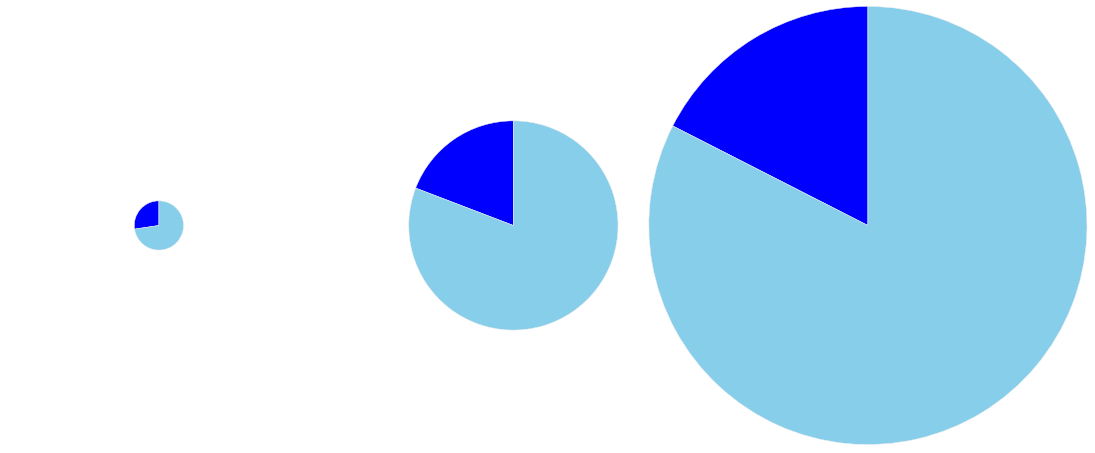

In [21]:

# Titel =  Pie SSF and LSF by category

sizes_A = Am_S, Am_L
sizes_B = Be_S, Be_L
sizes_C = Ca_S, Ca_L


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(18, 12))

# plt.setp(autotexts, size='x-small')
# autotexts[0].set_color('white')

ax1.pie(sizes_A, startangle=90, radius = Am_radius, colors = ['blue', 'skyblue'])


ax2.pie(sizes_B, startangle=90, radius = Be_radius, colors = ['blue', 'skyblue'])

# Adapt radius and text size for a smaller pie
ax3.pie(sizes_C, startangle=90, radius=Ca_radius, colors = ['blue', 'skyblue'])


plt.show()

In [22]:
Subsidies_SSF_types = Subsidies_SSF_2018.groupby(['Type'], as_index = False).sum()
Subsidies_SSF_types['SSF USD billion'] = Subsidies_SSF_types['SSF_USD']/1000000000
Subsidies_SSF_types['Total USD billion'] = Subsidies_SSF_types['Constant 2018 USD']/1000000000
Subsidies_SSF_types['LSF USD billion'] = Subsidies_SSF_types['Total USD billion'] - Subsidies_SSF_types['SSF USD billion']
Subsidies_SSF_types = Subsidies_SSF_types.sort_values(by = 'Total USD billion', ascending = False)
Subsidies_SSF_types_print = Subsidies_SSF_types.loc[:,['Type','SSF USD billion','LSF USD billion', 'Total USD billion']]
Subsidies_SSF_types_print.set_index('Type', inplace=True)
Subsidies_SSF_types_print['%SSF'] = Subsidies_SSF_types_print['SSF USD billion'] / Subsidies_SSF_types_print['Total USD billion'] *100

In [23]:
Subsidies_SSF_types_print


,SSF USD billion,LSF USD billion,Total USD billion,%SSF
Type,,,,
Fuel subsidies,0.575899,7.155055,7.730954,7.449266
Fisheries mangt.,1.281081,5.476826,6.757907,18.956775
Tax exemption,0.876376,4.442936,5.319312,16.475362
Fisheries dev. projects,0.774767,1.831575,2.606342,29.726226
Markt. & storage infrast.,0.765794,1.641136,2.406930,31.816214
MPAs,0.565635,1.817004,2.382639,23.739868
Fishing port develop.,0.730372,1.083996,1.814368,40.254905
Fishery R&D,0.191843,1.292526,1.484370,12.924234
Vessel buyback,0.039624,1.384355,1.423979,2.782626


In [24]:
Subsidies_SSF_types_short = Subsidies_SSF_types.loc[:,['Type','SSF USD billion','LSF USD billion']]
Subsidies_SSF_types_short.set_index('Type', inplace=True)

In [25]:
Subsidies_SSF_types_short = Subsidies_SSF_types_short.rename(index={'Tax exemption': 'Tax exemption (C)', 'Markt. & storage infrast.': 'Markt. & storage infrast. (C)',
                                                                    'Fishing port develop.': 'Fishing port develop. (C)',
                                                                    'Fishing access': 'Fishing access (C)',
                                                                    'Boat constsruct. & renov.': 'Boat constsruct. & renov. (C)',
                                                                    'Fuel subsidies': 'Fuel subsidies (C)',
                                                                    'Fisheries dev. projects': 'Fisheries dev. projects (C)',
                                                                    'MPAs':'MPAs (B)', 'Fisheries mangt.':'Fisheries mangt. (B)',
                                                                    'Fishery R&D':'Fishery R&D (B)',
                                                                    'Fisher assistance':'Fisher assistance (A)',
                                                                    'Vessel buyback':'Vessel buyback (A)',
                                                                    'Rural fisher communities':'Rural fisher communities (A)'})
# preparation for graph rename type names

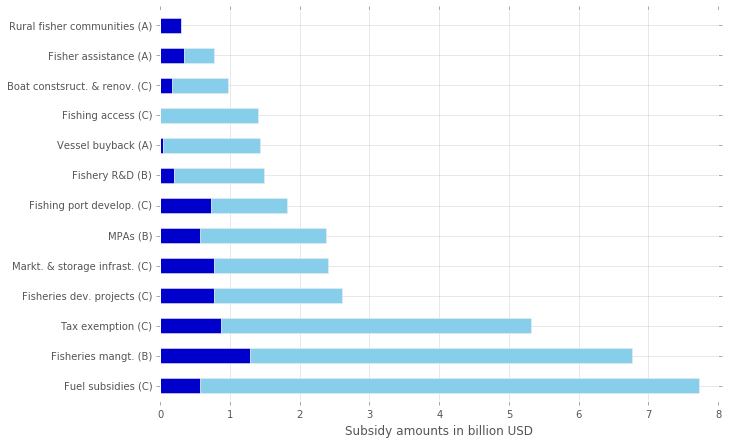

In [26]:
# Bar chart global SSF vs LSF subsidies by type
plt.rcParams['grid.color'] = 'lightgrey'
ax = Subsidies_SSF_types_short.plot.barh(stacked=True,  figsize=(10,7), color = ['mediumblue', 'skyblue'], legend = False)
ax.set_xlabel('Subsidy amounts in billion USD')
ax.set_ylabel('')
ax.set_facecolor("white")

In [27]:
# preparation for graph regions, exclude China from Asia and plot on its own

China_Regions_SSF = Subsidies_SSF_2018.loc[:,['RegionName','Country','Category','Constant 2018 USD', 'SSF_USD','LSF_USD']]

China_Regions_SSF['Region_Name'] = np.where(China_Regions_SSF['Country'] == 'China', China_Regions_SSF['RegionName'].replace('Asia','China'), China_Regions_SSF['RegionName'])
# China_Regions.to_csv("China_test.csv")
China_Regions_SSF.columns

Index(['RegionName', 'Country', 'Category', 'Constant 2018 USD', 'SSF_USD',
       'LSF_USD', 'Region_Name'],
      dtype='object')

In [28]:
China_Regions_SSF['Total USD billion'] = China_Regions_SSF['Constant 2018 USD']/1000000000
China_Regions_SSF['SSF USD billion'] = China_Regions_SSF['SSF_USD']/1000000000
China_Regions_SSF['LSF USD billion'] = China_Regions_SSF['LSF_USD']/1000000000
China_Regions_SSF


China_Regions_SSF = China_Regions_SSF.loc[:,['Region_Name', 'Category','Total USD billion','SSF USD billion', 'LSF USD billion']]

In [35]:
China_Regions_SSF_grouped = China_Regions_SSF.groupby(['Region_Name']).sum()
China_Regions_SSF_sorted = China_Regions_SSF_grouped.sort_values(by = 'Total USD billion', ascending = False)
Regions_SSF = China_Regions_SSF_sorted.loc[:,['SSF USD billion','LSF USD billion']]
Regions_SSF = Regions_SSF.rename(index={'South, Central America and Carribbean': 'SCAC$^{**}$',})
Regions_SSF = Regions_SSF.rename(index={'Asia': 'Asia$^{*}$',})
Regions_SSF_percent = Regions_SSF
Regions_SSF_percent['SSF%'] = (Regions_SSF_percent['SSF USD billion'] / (Regions_SSF_percent['SSF USD billion']+Regions_SSF_percent['LSF USD billion']))*100
Regions_SSF_percent

,SSF USD billion,LSF USD billion,SSF%
Region_Name,,,
Asia$^{*}$,3.020480,9.216635,24.682942
China,0.272166,6.989088,3.748195
Europe,0.746461,5.642292,11.683980
North America,1.069202,3.486706,23.468465
Africa,0.705080,1.393947,33.590803
SCAC$^{**}$,0.666424,1.331678,33.352844
Oceania,0.134416,0.696154,16.183575


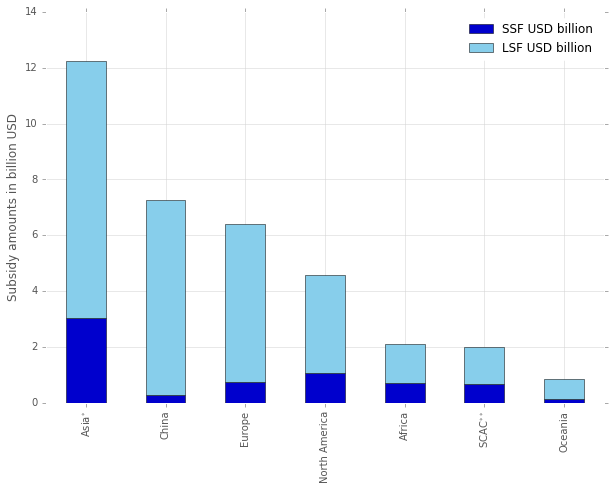

In [30]:
# xlabel : 'Subsidy estimates (USD in 2018)'
fig = Regions_SSF.plot.bar(stacked=True, figsize=(10,7), color = ['mediumblue', 'skyblue'], edgecolor = 'black')
fig.set_ylabel('Subsidy amounts in billion USD')
fig.set_xlabel('')
fig.set_facecolor("white")
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor("white")
# legend.set_facecolor("white")

plt.show()

In [31]:
# prep data to divide into Developed and Developing using UN scheme
Subsidies_SSF_Developed = Subsidies_SSF_2018.loc[:,['RegionName','Country','Category','Type','LSF_USD','SSF_USD']]

Countrydata_developed = Countrydata.loc[:,['Country','UN_Developed']]
Subsidies_SSF_Developed = pd.merge(left = Subsidies_SSF_Developed, right = Countrydata_developed, how = 'left' )
SSF_Developed_grouped = Subsidies_SSF_Developed.groupby(['UN_Developed','Category'], as_index=False).sum()



SSF_Developed_grouped['Total_USD'] = SSF_Developed_grouped['SSF_USD'] + SSF_Developed_grouped['LSF_USD']



In [32]:
# False_total = SSF_Developed_grouped['Total_USD'][0]
# True_total = SSF_Developed_grouped['Total_USD'][1] 

SSF_Developed_grouped.set_index('UN_Developed', inplace=True)
SSF_Developed_grouped = SSF_Developed_grouped.rename(index={False: 'Developing', True: 'Developed'})
SSF_Developed_grouped['SSF%'] = SSF_Developed_grouped['SSF_USD'] /SSF_Developed_grouped['Total_USD']*100
# SSF_Developed_grouped.to_csv("Output/developed_grouped.csv")
# make csv to output table 1

In [33]:
SSF_Developed_grouped

,Category,LSF_USD,SSF_USD,Total_USD,SSF%
UN_Developed,,,,,
Developing,Ambiguous,1.138312e+09,4.386349e+08,1.576947e+09,27.815456
Developing,Beneficial,4.259011e+09,9.837681e+08,5.242779e+09,18.764249
Developing,Capacity-enhancing,1.364404e+10,2.450605e+09,1.609465e+10,15.226212
Developed,Ambiguous,6.768317e+08,2.453982e+08,9.222299e+08,26.609222
Developed,Beneficial,4.327345e+09,1.054792e+09,5.382137e+09,19.598013
Developed,Capacity-enhancing,4.710961e+09,1.441030e+09,6.151991e+09,23.423799
